### Please Write Your VT PID Here: niket
### Reference (if any):

In [38]:
# import necessary packages and modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.nn.utils.rnn import pack_padded_sequence
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import os

# Image Captioning Using Encoder-Decoder Architecture

Simply, the encoder will take the image as input and encode it into a vector of feature values. The decoder will take this output from encoder as hidden state and starts to predict next words at each step. The following figure illustrates this:

<img src="figs/image_captioning_overview.jpg" width="600">
Figure 1. An overview of the encoder-decoder architecture
(image credit: <a href="https://link.springer.com/chapter/10.1007/978-3-030-04780-1_23">Deep Neural Network Based Image Captioning</a>)

You will use a pre-trained CNN as the encoder and Vanilla RNN/LSTM as decoder to predict the captions.

# Section 1.1 Data
Download dataset following the instructions. We are gonna use Flickr30k dataset, which consists of 31783 images and 158,915 captions. However, instead of using the whole dataset and "results.csv", we will follow Karpathy's Flickr30k annotations and use "dataset_flickr30k.json". Please move "dataset_flickr30k.json" to "flickr30k_images" folder.

## How to download the data (ARC)
Since the original Flickr30K dataset requires application, we will use the dataset from Kaggle. 

Step 1: Register a Kaggle account. https://www.kaggle.com/

Step 2: Log into ARC server in the terminal, e.g. Huckleberry.

Step 3: Install required packages.

    - if you're gonna use powerai on Huckleberry
        # step 1: request for GPU nodes
        salloc --partition=normal_q --nodes=1 --tasks-per-node=10 --gres=gpu:1 bash
        # or if you don't want a GPU, it will be faster to get a job
        salloc --partition=normal_q --nodes=1 --tasks-per-node=10 bash
        # step 2: load all necessary modules
        module load gcc cuda Anaconda3 jdk
        # step 3: activate the virtual environment
        source activate powerai16_ibm
        # step 4: for new packages(take tqdm for example)
        pip install --user kaggle nltk # on hulogin1/hulogin2
        
    - if you're gonna use your own conda environment, simply type
        pip install kaggle nltk
Step 4: Make sure you have kaggle. Type `kaggle`.

Step 5: Download your kaggle.json file from  https://www.kaggle.com/Your_Username/account. In API section, click Create New API Token. Then move you kaggle.json file to the path `/home/your_name_space/.kaggle/kaggle.json`.

Step 6: Download the dataset. Type `kaggle datasets download hsankesara/flickr-image-dataset`.

Step 7: Unzip the dataset. Type `unzip flickr-image-dataset.zip -x "flickr30k_images/flickr30k_images/flickr30k_images/*.jpg" -d "/path-to-Assignment_4/Assignment_4/"`

Step 8: You should have your dataset in `/path-to-Assignment_4/Assignment_4/flickr30k_images/`

Step 9: Move "dataset_flickr30k.json" to "flickr30k_images" folder.

**Note** that you might want to use `nltk.download('punkt')` and `torchvision.models.resnet50(pretrained=True)` before you enter the GPU node.

## How to download the data (Google Colab)
Step 1: Register a Kaggle account.  https://www.kaggle.com/

Step 2: Download your kaggle.json file from  https://www.kaggle.com/Your_Username/account. In API section, click Create New API Token.

Step 3: As we did before, upload all files on Google Drive and open Google Colab.

Step 4: Install required packages.
    
    ! pip install -q kaggle nltk

Step 5: Insert a cell.
    
    
    from google.colab import files
    files.upload()
    
    
    Upload `kaggle.json` you just downloaded.
    
Step 6: Move `kaggle.json` to the right place,
    
    
     ! mkdir ~/.kaggle
     ! cp kaggle.json ~/.kaggle/
    

Step 7: Change the permission.
    
    ! chmod 600 ~/.kaggle/kaggle.json

Step 8: Download.
    
    !kaggle datasets download hsankesara/flickr-image-dataset

Step 9: Move it to your drive and unzip it.
    
    unzip flickr-image-dataset.zip -x "flickr30k_images/flickr30k_images/flickr30k_images/*.jpg" -d "/path-to-Assignment_4/Assignment_4/"
    
Step 10: Move "dataset_flickr30k.json" to "flickr30k_images" folder.

### Colab Setup: 
- Below are some basic steps for colab setup. 
- Make changes based on requirements.
- Comment out in case of ARC or your local device with powerful GPU.

**Note: For Google Colab give proper paths in this notebook and in dataloader.py if required.**

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
import sys
# modify "customized_path_to_homework", path of folder in drive, where you uploaded your homework
path_to_homework = "/content/drive/My Drive/DL_Fall_2020/Assignment_4/"
sys.path.append(path_to_homework)

In [ ]:
from google.colab import files
files.upload()
 
 


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sharmaniket","key":"530732fb8cc28afff5bab3e7769bfc9d"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download hsankesara/flickr-image-dataset

100% 8.16G/8.16G [03:09<00:00, 37.5MB/s]
100% 8.16G/8.16G [03:09<00:00, 46.3MB/s]


In [36]:
from dataloader import Flickr30k, get_loader

# Section 1.2 Take a look at the data

In [41]:
# visualize images and captions
flickr = Flickr30k(split='val', root="/content/drive/My Drive/DL_Fall_2020/Assignment_4/flickr30k_images/")   # load validation set as an example
flickr()

-------flickr30k--------
image root: /content/drive/My Drive/DL_Fall_2020/Assignment_4/flickr30k_images/flickr30k_images
dataset split: val
the length of the dataset: 1014


['A group of people where some are holding yellow tote bags under trees and a sign that says start.', 'A crowd of people are gathered at the start sign for the walk.', 'A group of people gathered around the starting line of a race.', 'A large crowd is standing around the start line.', 'A crowd loiters near the start of a marathon.']


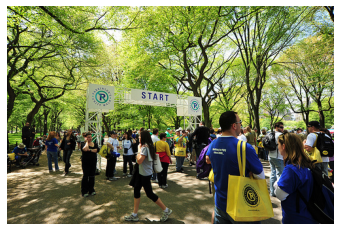

In [42]:
# show a random image and its captions
img_id = np.random.randint(len(flickr))
img = flickr.get_img(img_id)
captions = flickr.get_captions(img_id)

plt.figure()
plt.imshow(img)
plt.axis('off')

print(captions)

In [43]:
del flickr

# Section 1.3 Build vocabulary
We need to build a vocabulary for our dataset. The vocabulary stores all the words and their indices. We will use it to embed and recover the words.

In [44]:
import nltk
import pickle
import json
from tqdm import tqdm
from collections import Counter
nltk.download('punkt') # You can comment this line once you've downloaded 'punkt'

class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {'<pad>': 0, '<unk>': 1, '<start>': 2, '<end>': 3}  # follow Pytorch padding rules: pad sentence with zero.
        self.idx = 4
        self.idx2word = {v: k for k, v in self.word2idx.items()}

    def __call__(self, key):
        if key not in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[key]

    def __len__(self):
        return len(self.word2idx)

    def add_word(self, word):
        """
        Add new words
        :param word: word
        """
        if word not in self.word2idx:
            self.word2idx[word] = self.idx  # add a new word
            self.idx2word[self.idx] = word
            self.idx += 1

    def reverse(self, value):
        """
        From idx to words.
        :param value: index
        :return:
        """
        if value not in self.idx2word:
            return self.idx2word[1]  # return '<unk>' if the word is unseen before.
        return self.idx2word[value]

def build_vocab(json_file=path_to_homework+ '/flickr30k_images/dataset_flickr30k.json', threshold=3):
    with open(json_file) as f:
            data = json.load(f)
    f.close()
    counter = Counter()
    for img_idx in tqdm(range(len(data['images']))):
        img_annos = data['images'][img_idx]
        for sent_idx in range(len(img_annos['sentids'])):
#             tokens = img_annos['sentences'][sent_idx]['tokens']  # directly load tokens

            caption = img_annos['sentences'][sent_idx]['raw']
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            
            counter.update(tokens)

    # If the number of words is less than threshold we don't count it.
    words = [word for word, cnt in counter.items() if cnt >= threshold]


    # create a Vocabulary class
    vocab = Vocabulary()

    # add words to Vocab
    for i, word in enumerate(words):
        vocab.add_word(word)

    return vocab

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [45]:
# let's create a vocabulary for future usage
vocab_path = path_to_homework + '/flickr30k_images/vocab.pkl'
if not os.path.isfile(vocab_path):  # if we don't have vocab, create one
    vocab = build_vocab(json_file=path_to_homework + '/flickr30k_images/dataset_flickr30k.json', threshold=3)
    with open(vocab_path, 'wb') as f:
        pickle.dump(vocab, f)
    print("Total vocabulary size: {}".format(len(vocab)))
    print("Saved the vocabulary wrapper to '{}'".format(vocab_path))
else:  # if we have, load the existing vocab
    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)
    print('vocab loaded!')
    print('the size of vocab:', len(vocab))
f.close()

100%|██████████| 31014/31014 [00:19<00:00, 1579.09it/s]


Total vocabulary size: 9991
Saved the vocabulary wrapper to '/content/drive/My Drive/DL_Fall_2020/Assignment_4//flickr30k_images/vocab.pkl'


In [46]:
vocab_path = path_to_homework + '/flickr30k_images/vocab.pkl'
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)
print('vocab loaded!')
print('the size of vocab:', len(vocab))
# print(vocab.word2idx.keys())
# print(vocab.idx2word)

# check some random words
for i in range(3):
    random_idx = np.random.randint(len(vocab))
    print('word: {}, index: {}'.format(list(vocab.word2idx.keys())[random_idx], vocab(list(vocab.word2idx.keys())[random_idx])))

vocab loaded!
the size of vocab: 9991
word: busch, index: 5481
word: skinned, index: 8256
word: applaud, index: 6205


# Section 2 Vanilla RNN [45 pts]
# Section 2.1 Design the Network: Encoder [5 pts]
Implement the baseline model by using pre-trained ResNet-50 as the encoder and Vanilla RNN as the decoder. Note that we will remove the last layer (fc layer) of ResNet-50 and add a trainable linear layer to finetune it for our task. During the training, we will **freeze** the layer before the fc layer. The encoder should output a feature vector of a fixed size for each image.

In [47]:
import torchvision.models as models
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.nn.utils.rnn import pack_padded_sequence
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import os

In [48]:
class Encoder(nn.Module):
    def __init__(self, emb_dim):
        """
        Use ResNet-50 as encoder.
        :param emb_dim: output size of ResNet-50.
        """
        super(Encoder, self).__init__()
        
        #self.resnet = torchvision.models.resnet50(pretrained=True)
        ###########Your code###############
        # freeze the parameters
        #self.resnet = models.resnet50(pretrained=True)
        resnet = models.resnet50(pretrained=True)
        # replace the last layer (fc layer) with a trainable layer for finetuning
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        # remove last fully connected layer
        modules = list(resnet.children())[:-1]
        
        # build the new resnet
        self.resnet = nn.Sequential(*modules)
        
        # our additional Fully connected layer with an output = the embbed size
        # to feed the rnn
        self.embed = nn.Linear(resnet.fc.in_features, emb_dim)

    def forward(self, x):
        x = self.resnet(x)  # output shape: [N, emb_dim]
        #flatten for our additional fc layer
        x = x.view(x.size(0), -1)
        
        x = self.embed(x)
        return x

# Section 2.2 Design the Network: Decoder [10 pts]
During decoding, we will train a RNN (https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN) to learn the structure of the caption text throught "**Teacher Forcing**". Teacher forcing works by using the teaching signal from the training dataset at the current time step, $target(t)$, as input in the next time step $x(t+1) = target(t)$, rather than the output $y(t)$ generated by the network. 

As shown in Figure 1 above, RNN will take three inputs: the *current feature*, hidden state ($h_0$) and cell state ($c_0$). The *current feature* for the first step should be the output of encoder to predict '\<start\>' word. Hidden states for this step should be set to None. Then in the second step '\<start\>' will be passed into RNN as the input, and so on.

To use '\<start\>' or any subsequent word as current feature, get its index from the vocabulary you created, convert it to one-hot vector and pass it through a linear layer to embed into a feature (or you can take advantage of Pytorch’s nn.Embedding which does one-hot encoding + linear layer for you).

For convenience, you might want to 'pad' the captions in a mini-batch to convert them into fixed length. You can use 'pack_padded_sequence' function.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers=1, dropout = 0):
        """
        Use RNN as decoder for captions.
        :param emb_dim: Embedding dimensions.
        :param hidden_dim: Hidden states dimensions.
        :param num_layers: Number of RNN layers.
        :param vocab_size: The size of Vocabulary.
        :param dropout: the probability for dropout.
        """
        super(Decoder, self).__init__()
        self.max_length = 40  # the maximum length of a sentence, in case it's trapped
        
        #############Your code############
        # you need to implement a Vanilla RNN for the decoder. Take a look at the official documentation.
        # https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN
        
        # one-hot encoding + linear layer
        
        # vanilla rnn network
        
        # output layer
        
        self.hidden_dim = hidden_dim
        
        # Our embedding layer
        self.word_embeddings = nn.Embedding(vocab_size, emb_dim)
        
        self.rnn = nn.RNN(emb_dim,hidden_dim, num_layers, batch_first=True)
        
        # The linear layer maps the hidden state output of the RNN to the number of words we want:
        # vocab_size
        self.linear = nn.Linear(self.hidden_dim, vocab_size)
        
    
   
        

    def forward(self, encode_features, captions, lengths):
        """
        Feed forward to generate captions. Note that you need to pad the input so they have the same length
        :param encode_features: output of encoder, size [N, emb_dim]
        :param captions: captions, size [N, max(lengths)]
        :param lengths: a list indicating valid length for each caption. size is (batch_size).
        """
        #############Your Code###################
        # compute the embedding using one-hot technique and linear function
        
        # concatenate the encoded features from encoder and embeddings
                
        # feed into RNN.
        
        # output layer
        
       

        # Create embedded word vectors for each word in the captions
        embeddings = self.word_embeddings(captions)
        
        # Stack the features and captions
        embeddings = torch.cat((encode_features.unsqueeze(1), embeddings), dim=1) 
        packed = pack_padded_sequence(embeddings, lengths, batch_first = True)

       # rnn_out, self.hidden = self.rnn(embeddings, self.hidden) 
        rnn_out ,hidden = self.rnn(packed)
        
        #out = self.linear(rnn_out)
        
        #outputs = out[:, :-1]
           
        outputs = self.linear(rnn_out[0])

        return outputs

# Encoder-decoder [10 pts]
Now we need to put our encoder and decoder together. 

In the sample_generate stage, the idea is to “let the network run on its own”, predicting the next word, and then use the network’s prediction to obtain the next input word. There are at least two ways to obtain the next word.

- **Deterministic**: Take the maximum output at each step.
- **Stochastic**: Sample from the probability distribution. To get the distribution, we need to compute the weighted softmax of the outputs: $y^i = \exp(o^j/\tau) / \sum_n \exp(o^n/\tau)$, where $o^j$ is the output from the last layer, $n$ is the size of the vocabulary, and $\tau$ is the so-called "temperature". By doing this, you should get a different caption each time.

In [ ]:
class Vanilla_rnn(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers=1, dropout=0):
        """
        Encoder-decoder vanilla RNN.
        :param vocab_size: the size of Vocabulary.
        :param emb_dim: the dimensions of word embedding.
        :param hidden_dim: the dimensions of hidden units.
        :param num_layers: the number of RNN layers.
        :param dropout: dropout probability
        """
        super(Vanilla_rnn, self).__init__()
        #self.max_length = self.Decoder.max_length
        #########Your Code################
        # Encoder: ResNet-50
        self.Encoder = Encoder(emb_dim)
        # Decoder: RNN
        self.Decoder = Decoder(vocab_size, emb_dim, hidden_dim, num_layers)
        self.soft = nn.Softmax(dim = 1)
        #self.max_length = self.Decoder.max_length
        self.max_length = 40
    def forward(self, x, captions, lengths):
        """
        Feed forward.
        :param x: Images, [N, 3, H, W]
        :param captions: encoded captions, [N, max(lengths)]
        :param lengths: a list indicating valid length for each caption. length is (batch_size).
        :return: output logits, usually followed by a softmax layer.
        """
        ##########Your code###################
        # forward passing
        features = self.Encoder(x)
        outputs = self.Decoder(features, captions,  lengths)
        
        return outputs

    def sample_generate(self, x, states=None, mode='Deterministic', temperature=5.0):
        """
        Generate samples during the evaluation.
        
        :param x: input image
        :param states: rnn states
        :param mode: which mode we use.  
         - 'Deterministic': Take the maximum output at each step.
         - 'Stochastic': Sample from the probability distribution from the output layer.
        :param temperature: will be used in the stochastic mode
        :return: sample_idxs. Word indices. We can use vocab to recover the sentence later.
        """
        sample_idxs = []  # record the index of your generated words
        #################Your Code##################
        # compute the encoded features
        features = self.Encoder(x).unsqueeze(1)
        # decide which mode we use
        if mode == 'Deterministic':
            # take the maximum index after the softmax
           for itr in range(self.max_length):
               hiddens, states = self.Decoder.rnn(features, states)
               outputs = self.Decoder.linear(hiddens.squeeze(1))
               predicted = outputs.max(1)[1]
               
               sample_idxs.append(predicted)
               features = self.Decoder.word_embeddings(predicted).unsqueeze(1)
           sample_idxs = torch.stack(sample_idxs,dim =1)

        elif mode == 'Stochastic':
            # sample from the probability distribution after the softmax
            # Hint: use torch.multinomial() to sample from a distribution.
            for itr in range(self.max_length):
                hiddens, states = self.Decoder.rnn(features, states)
                outputs = self.Decoder.linear(hiddens.squeeze(1))
                probs = F.softmax(outputs.div(temperature), dim = 1)
                predicted = torch.multinomial(probs.data,1)
                sample_idxs.append(predicted[:,0])
                inputs = self.Decoder.word_embeddings(predicted[:,0].unsqueeze(1))
            sample_idxs = torch.stack(sample_idxs,dim =1)
        return sample_idxs

# Section 2.3 Training [10 pts]
Train your encoder-decoder. You might also want to check the output sentence every epoch.

In [ ]:
# some hyperparameters, you can change them
## training parameters
batch_size = 256
lr = 1e-2
num_epochs = 50
weight_decay = 0.0
log_step = 50

## network architecture
emb_dim = 1024
hidden_dim = 256
num_layers = 1 # number of RNN layers
dropout = 0.0

## image transformation
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #     transforms.RandomCrop(224, pad_if_needed=True),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225))])

## Output directory
output_dir = path_to_homework + '/checkpoints/rnn/'
os.makedirs(output_dir, exist_ok=True)

## device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [53]:
# Validation code here. We are gonna use this during the training. 
def val(model, data_loader, vocab):
    """
    Inputs:
    :param model: the encoder-decoder network.
    :param data_loader: validation data loader
    :param vocab: pre-built vocabulary
    Output:
    the mean value of validation losses
    """
    print('Validating...')
    val_loss = []
    total_step = len(data_loader)
    for itr, (images, captions, lengths) in enumerate(data_loader):
        #######Your Code#########
        # forward inputs and compute the validation loss
        
        # record the validation loss
        #images, captions = data_loader['image'], data_loader['caption']
        #images = images.type(torch.FloatTensor)
        images = images.to(device)
        captions = captions.to(device)
            
        #features = Encoder(images)
        #outputs = Decoder(features, captions, lengths)
        
        targets = pack_padded_sequence(captions, lengths,batch_first = True)[0]
        
        outputs = model(images, captions, lengths)

        loss = criterion(outputs, targets)
        #optimizer.step()
        #loss = criterion(outputs.contiguous().view(-1, vocab_size), captions.view(-1))
            
        val_loss.append(loss.detach().cpu().numpy())
        





        # Print current loss
        if itr % log_step == 0:
           print('Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'.format(itr, total_step, loss.item(), np.exp(loss.item())))
    
    # (optional) you might also want to print out the sentence to see the qualitative performance of your model. 
    # You can use deterministic mode to generate sentences
    

    return np.mean(val_loss)


In [ ]:
# Training code here


train_data_loader = get_loader(root=path_to_homework + '/flickr30k_images/', split='train', vocab=vocab, 
                               transform=transform, batch_size=batch_size, shuffle=True, num_workers=4)
val_data_loader = get_loader(root=path_to_homework + '/flickr30k_images/', split='val', vocab=vocab, 
                               transform=transform, batch_size=8, shuffle=True, num_workers=4)

model = Vanilla_rnn(vocab_size=len(vocab), emb_dim=emb_dim, hidden_dim=hidden_dim, 
                   num_layers=1, dropout=dropout).to(device)    # build a model

# loss and optimizer
criterion = nn.CrossEntropyLoss()  # CE loss
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                      step_size=5,
                                      gamma=0.5)  # decay LR by a factor of 0.5 every 10 epochs. You can change this

# logs
Train_Losses = []  # record average training loss each epoch
Val_Losses = []   # record average validation loss each epoch
total_step = len(train_data_loader)  # number of iterations each epoch
best_val_loss = np.inf

# start training
print('Start training...')
import time
tic = time.time()
for epoch in range(num_epochs):
    print('Switch to training...')
    model.train()
    Train_loss_iter = []  # record the the training loss each iteration
    for itr, (images, captions, lengths) in enumerate(train_data_loader):
        ########Your Code###########
        # train your model
        #images, captions = train_data_loader['image'], train_data_loader['caption']
        #images = images.type(torch.FloatTensor)
        images = images.to(device)
        captions = captions.to(device)
            
        #features = Encoder(images)
        #outputs = Decoder(features, captions, lengths)
        
        targets = pack_padded_sequence(captions, lengths,batch_first = True)[0].to(device)
        optimizer.zero_grad()

        outputs = model(images, captions, lengths)
         
        criterion = nn.CrossEntropyLoss()
        loss = criterion(outputs,targets)
        
        loss.backward()
        optimizer.step()
        

        # record the training loss
        
        #step += 1
        # print log info
        if itr % log_step == 0:
            # print current loss and perplexity
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                      .format(epoch, num_epochs, itr, total_step, loss.item(), np.exp(loss.item())))
    scheduler.step()
    Train_Losses.append(np.mean(Train_loss_iter))
    np.save(os.path.join(output_dir, 'TrainingLoss_rnn.npy'), Train_Losses)  # save the training loss
    
    model.eval()
    # (optional) generate a sample during the training, you can use deterministic mode
    # Your code
    
    
    # validation
    Val_Losses.append(val(model, val_data_loader, vocab))
    np.save(os.path.join(output_dir, 'ValLoss_rnn.npy'), Val_Losses) # save the val loss
    
    # save model
    if Val_Losses[-1] < best_val_loss:
        best_val_loss = Val_Losses[-1]
        print('updated best val loss:', best_val_loss)
        print('Save model weights to...', output_dir)
        torch.save(model.state_dict(), 
                   os.path.join(output_dir, 'vanilla_rnn-best.pth'.format(epoch + 1, itr + 1)))

print('It took: {} s'.format(time.time() - tic))

Start training...
Switch to training...
Epoch [0/50], Step [0/114], Loss: 9.2853, Perplexity: 10778.1624
Epoch [0/50], Step [50/114], Loss: 3.8652, Perplexity: 47.7145
Epoch [0/50], Step [100/114], Loss: 3.6875, Perplexity: 39.9444
Validating...


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Step [0/127], Loss: 3.6941, Perplexity: 40.2108
Step [50/127], Loss: 3.4769, Perplexity: 32.3591
Step [100/127], Loss: 3.4743, Perplexity: 32.2748
updated best val loss: 3.6330473
Save model weights to... /content/drive/My Drive/DL_Fall_2020/Assignment_4//checkpoints/rnn/
Switch to training...
Epoch [1/50], Step [0/114], Loss: 3.6542, Perplexity: 38.6365
Epoch [1/50], Step [50/114], Loss: 3.4728, Perplexity: 32.2262
Epoch [1/50], Step [100/114], Loss: 3.5902, Perplexity: 36.2401
Validating...
Step [0/127], Loss: 3.1044, Perplexity: 22.2962
Step [50/127], Loss: 3.6910, Perplexity: 40.0863
Step [100/127], Loss: 3.5613, Perplexity: 35.2086
updated best val loss: 3.5487056
Save model weights to... /content/drive/My Drive/DL_Fall_2020/Assignment_4//checkpoints/rnn/
Switch to training...
Epoch [2/50], Step [0/114], Loss: 3.4680, Perplexity: 32.0741
Epoch [2/50], Step [50/114], Loss: 3.4918, Perplexity: 32.8440
Epoch [2/50], Step [100/114], Loss: 3.4428, Perplexity: 31.2755
Validating...
Step

# Section 2.4 Evaluation [10 pts]

In [ ]:
## evaluation code
from tqdm import tqdm, tqdm_notebook
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
smoother = SmoothingFunction()

def caption_generator(model, images, vocab, img_ids, captions, mode='Deterministic', temperature=1.0):
    """
    Generate captions.
    :param mode:
    :return:
    """
    sample_idxs = model.sample_generate(images, mode=mode,
                                        temperature=temperature).data.cpu().numpy()  # [N, max_length]
    for i, sentence in enumerate(sample_idxs):  # every sentence in this batch
        sentence_caption = ''
        for word_idx in sentence:
            word = vocab.idx2word[word_idx]
            if word != '<start>' and word != '<end>':
                if word == '.':
                    sentence_caption += '.'
                else:
                    sentence_caption += word + ' '
            if word == '<end>':
                break
        captions.append({'caption': sentence_caption})
        # captions.append(sentence_caption)

    return captions

def run_test(model, data_loader, vocab, mode='Deterministic', temperature=1.0):
    """
    Run your model on the test set.
    Inputs:
    :param model: the model you use
    :param data_loader: the data_loader
    :param mode: use 'deterministic' or 'stochastic'
    Outputs:
    :param predictions
    """
    predictions = []
    for itr, (images, captions, lengths) in enumerate(tqdm(data_loader)):
        images = Variable(images).to(device)
        captions = Variable(captions).to(device)
        outputs = model(images, captions, lengths)
        
        img_ids = list(range(itr * data_loader.batch_size, (itr + 1) * data_loader.batch_size))
        predictions = caption_generator(model, images, vocab, img_ids, 
                                        predictions, mode=mode, temperature=temperature)
        
    return predictions

def evaluation(model, vocab, data_path=path_to_homework + '/flickr30k_images/', mode='Deterministic', temperature=1.0,
               split='test'):
    """
    Evaluate the performance of your model on the test set using BLEU scores.
    Inputs:
    :param model: the model you use
    :param weight_path: the directory to the weights of your model
    :param vocab: vocabulary
    :param data_path: the directory to the dataset
    :param mode: use 'deterministic' or 'stochastic'
    Outputs:
    :param predictions
    """
    # data loader
    test_data_loader = get_loader(root=path_to_homework + '/flickr30k_images/', split=split, vocab=vocab, 
                                  transform=transform, batch_size=8, shuffle=False, num_workers=4)
    
    # run your model on the test set
    print('Run on the test set...')
    preds = run_test(model, test_data_loader, vocab, mode, temperature)
    
    # load the groundtruth
    gt = test_data_loader.dataset.annos
    
    # evaluate the performance using BLEU score
    score1 = 0
    score2 = 0
    score3 = 0
    score4 = 0
    
    print('Computing BLEU')
    for itr in tqdm(range(len(gt))):
        candidate = preds[itr]['caption']
        reference = [sent['raw'] for sent in gt[itr]['sentences']]
        score1 += sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=smoother.method1)
        score2 += sentence_bleu(reference, candidate, weights=(0, 1, 0, 0), smoothing_function=smoother.method1)
        score3 += sentence_bleu(reference, candidate, weights=(0, 0, 1, 0), smoothing_function=smoother.method1)
        score4 += sentence_bleu(reference, candidate, weights=(0, 0, 0, 1), smoothing_function=smoother.method1)
    
    bleu1 = 100 * score1/len(gt)
    bleu2 = 100 * score2/len(gt)
    bleu3 = 100 * score3/len(gt)
    bleu4 = 100 * score4/len(gt)
    
    return bleu1, bleu2, bleu3, bleu4

- Test your outputs in the **Deterministic** way by using BLEU scores. You should at achieve a BLEU 4 of 25.

In [ ]:
## Evaluate your model using BLEU score. Use Deterministic mode.

## Image transformation
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #     transforms.RandomCrop(224, pad_if_needed=True),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225))])

## Evaluate your model using BLEU score. Use Deterministic mode
model = Vanilla_rnn(vocab_size=len(vocab), emb_dim=emb_dim, hidden_dim=hidden_dim, 
                   num_layers=1, dropout=dropout).to(device)  # build a model
model.load_state_dict(torch.load(path_to_homework + '/checkpoints/rnn/vanilla_rnn-best.pth', map_location=torch.device('cpu')))
model.eval()
bleu1, bleu2, bleu3, bleu4 = evaluation(model, vocab, mode='Deterministic')
print("BLEU 1:{}, BLEU 2:{}, BLEU 3:{}, BLEU 4:{}".format(bleu1, bleu2, bleu3, bleu4))

  0%|          | 0/125 [00:00<?, ?it/s]

Run on the test set...


  2%|▏         | 23/1000 [00:00<00:04, 220.41it/s]

Computing BLEU


100%|██████████| 1000/1000 [00:04<00:00, 232.33it/s]

BLEU 1:89.68767687069148, BLEU 2:63.75724619747129, BLEU 3:41.23849656594904, BLEU 4:27.7544551175118


- Try different temperatures (e.g. 0.1, 0.2, 0.5, 1.0, 1.5, 2, etc.) during the generation. Report BLEU scores for at least 3 different temperatures.

BLEU score = 27.75 (for temperature = 1)

In [ ]:
## Use at least 3 different temperatures to generate captions on the test set. Report the BLEU scores.
# Your code here
#for temperature =[0.2,2,4]
#temperature = 0.1


bleu1, bleu2, bleu3, bleu4 = evaluation(model, vocab, mode ='Stochastic',temperature = 0.2)
print("Temperature = 0.2/")
print("BLEU 1:{}, BLEU 2:{}, BLEU 3:{}, BLEU 4:{}".format(bleu1, bleu2, bleu3, bleu4))




# End of code

            BLEU 4        


In [ ]:
bleu1, bleu2, bleu3, bleu4 = evaluation(model, vocab, mode='Deterministic',temperature = 2)
print("Temperature = 2/")
print("BLEU 1:{}, BLEU 2:{}, BLEU 3:{}, BLEU 4:{}".format(bleu1, bleu2, bleu3, bleu4))

  0%|          | 0/125 [00:00<?, ?it/s]

Run on the test set...


  2%|▏         | 22/1000 [00:00<00:04, 217.09it/s]

Computing BLEU


100%|██████████| 1000/1000 [00:04<00:00, 231.92it/s]

Temperature = 2/
BLEU 1:89.68767687069148, BLEU 2:63.75724619747129, BLEU 3:41.23849656594904, BLEU 4:27.7544551175118


In [ ]:
bleu1, bleu2, bleu3, bleu4 = evaluation(model, vocab, mode='Deterministic',temperature = 4)
print("Temperature = 4")
print("BLEU 1:{}, BLEU 2:{}, BLEU 3:{}, BLEU 4:{}".format(bleu1, bleu2, bleu3, bleu4))

  0%|          | 0/125 [00:00<?, ?it/s]

Run on the test set...


  2%|▏         | 23/1000 [00:00<00:04, 229.14it/s]

Computing BLEU


100%|██████████| 1000/1000 [00:04<00:00, 230.66it/s]

Temperature = 4
BLEU 1:89.68767687069148, BLEU 2:63.75724619747129, BLEU 3:41.23849656594904, BLEU 4:27.7544551175118


# Section 3 Variations [55 pts]
## Section 3.1 LSTM [35 pts]
## Section 3.1.1 Decoder: LSTM [5 pts]
This time, replace the RNN module with an LSTM module.

In [49]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers=1, dropout=0):
        """
        Use LSTM as decoder for captions.
        :param emb_dim: Embedding dimensions.
        :param hidden_dim: Hidden states dimensions.
        :param num_layers: Number of LSTM layers.
        :param vocab_size: The size of Vocabulary.
        :param dropout: dropout probability
        """
        super(Decoder, self).__init__()

        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        #############Your code############
        # you need to implement a LSTM for the decoder. Take a look at the official documentation.
        # https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM
        
        # one-hot encoding + linear layer
        
        # LSTM network
        
        # output layer
                
               
                
        # Our embedding layer
        self.word_embeddings = nn.Embedding(vocab_size, emb_dim)
        
        self.lstm = nn.LSTM(emb_dim,hidden_dim, num_layers, batch_first=True)
        
        # The linear layer maps the hidden state output of the LSTM to the number of words we want:
        
        self.linear = nn.Linear(self.hidden_dim, vocab_size)
    def forward(self, encode_features, captions, lengths):
        """
        Feed forward to generate captions.
        :param encode_features: output of encoder, size [N, emb_dim]
        :param captions: captions, size [N, max(lengths)]
        :param lengths: a list indicating valid length for each caption. length is (batch_size).
        """
        #############Your Code###################
        # compute the embedding using one-hot technique and linear function
        
        # concatenate the encoded features from encoder and embeddings
                
        # feed into RNN
        
        # output layer
        
        embeddings = self.word_embeddings(captions)
        
        # Stack the features and captions
        embeddings = torch.cat((encode_features.unsqueeze(1), embeddings), dim=1) 
        packed = pack_padded_sequence(embeddings, lengths, batch_first = True)

       # rnn_out, self.hidden = self.rnn(embeddings, self.hidden) 
        lstm_out ,hidden = self.lstm(packed)
        
        #out = self.linear(rnn_out)
        
        #outputs = out[:, :-1]
           
        outputs = self.linear(lstm_out[0])

        return outputs

## Encoder-Decoder [5 pts]

In [58]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers=1, dropout=0):
        """
        Encoder-decoder vanilla RNN.
        :param vocab_size: the size of Vocabulary.
        :param emb_dim: the dimensions of word embedding.
        :param hidden_dim: the dimensions of hidden units.
        :param num_layers: the number of RNN layers.
        """
        super(LSTM, self).__init__()
       
        #########Your Code################
        # Encoder: ResNet-50
     
        # Decoder: LSTM

        
        #self.max_length = self.Decoder.max_length
        #########Your Code################
        # Encoder: ResNet-50
        self.Encoder = Encoder(emb_dim)
        # Decoder: LSTM
        self.Decoder = Decoder(vocab_size, emb_dim, hidden_dim, num_layers)
        self.soft = nn.Softmax(dim = 1)
        #self.max_length = self.Decoder.max_length
        self.max_length = 30

    def forward(self, x, captions, lengths):
        """
        Feed forward.
        :param x: Images, [N, 3, H, W]
        :param captions: encoded captions, [N, max(lengths)]
        :param lengths: a list indicating valid length for each caption. length is (batch_size).
        :return: output logits, usually followed by a softmax layer.
        """
        ##########Your code###################
        # forward passing
        features = self.Encoder(x)
        outputs = self.Decoder(features, captions,  lengths)
        return outputs

    def sample_generate(self, x, states=None, mode='Deterministic', temperature=5.0):
        """
        Generate samples during the evaluation.
        
        :param x: input image
        :param states: rnn states
        :param mode: which mode we use.  
         - 'Deterministic': Take the maximum output at each step.
         - 'Stochastic': Sample from the probability distribution from the output layer.
        :param temperature: will be used in the stochastic mode
        :return: sample_idxs. Word indices. We can use vocab to recover the sentence.
        """
        #sample_idxs = []
        #################Your Code##################
        # compute the encoded features
        
        # decide which mode we use
        #if mode == 'Deterministic':
            
        #elif mode == 'Stochastic':

        sample_idxs = []  # record the index of your generated words
        #################Your Code##################
        # compute the encoded features
        features = self.Encoder(x).unsqueeze(1)
        # decide which mode we use
        if mode == 'Deterministic':
            # take the maximum index after the softmax
           for itr in range(self.max_length):
               hiddens, states = self.Decoder.lstm(features, states)
               outputs = self.Decoder.linear(hiddens.squeeze(1))
               predicted = outputs.max(1)[1]
               
               sample_idxs.append(predicted)
               features = self.Decoder.word_embeddings(predicted).unsqueeze(1)
           sample_idxs = torch.stack(sample_idxs,dim =1)

        elif mode == 'Stochastic':
            # sample from the probability distribution after the softmax
            # Hint: use torch.multinomial() to sample from a distribution.
            for itr in range(self.max_length):
                hiddens, states = self.Decoder.lstm(features, states)
                outputs = self.Decoder.linear(hiddens.squeeze(1))
                probs = F.softmax(outputs.div(temperature), dim = 1)
                predicted = torch.multinomial(probs.data,1)
                sample_idxs.append(predicted[:,0])
                inputs = self.Decoder.word_embeddings(predicted[:,0].unsqueeze(1))
            sample_idxs = torch.stack(sample_idxs,dim =1)
        
        return sample_idxs

## Section 3.1.2 Training [10 pts]
Use the same set of hyper-parameters (hidden units, optimizer, learning rate etc.) for both models.

In [51]:
# some hyperparameters, you can change them
## training parameters
batch_size = 256
lr = 1e-2
num_epochs = 50
weight_decay = 0.0
log_step = 50

## network architecture
emb_dim = 1024
hidden_dim = 256
num_layers = 1 # number of RNN layers
dropout = 0.0

## image transformation
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #     transforms.RandomCrop(224, pad_if_needed=True),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225))])

## Output directory
output_dir = path_to_homework + '/checkpoints/lstm/'
os.makedirs(output_dir, exist_ok=True)

In [54]:
# Training code here
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


train_data_loader = get_loader(root=path_to_homework + '/flickr30k_images/', split='train', vocab=vocab,
                               transform=transform, batch_size=batch_size, shuffle=True, num_workers=12)
val_data_loader = get_loader(root=path_to_homework + '/flickr30k_images/', split='val', vocab=vocab,
                             transform=transform, batch_size=8, shuffle=True, num_workers=4)

model = LSTM(vocab_size=len(vocab), emb_dim=emb_dim, hidden_dim=hidden_dim, 
                   num_layers=1, dropout=dropout).to(device)  # build a model

# loss and optimizer
criterion = nn.CrossEntropyLoss().to(device)  # CE loss
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                      step_size=5,
                                      gamma=0.5)  # decay LR by a factor of 0.5 every 10 epochs. You can change this

# logs
Train_Losses = []  # record average training loss each epoch
Val_Losses = []   # record average validation loss each epoch
total_step = len(train_data_loader)  # number of iterations each epoch
best_val_loss = np.inf

# start training
print('Start training...')
import time
tic = time.time()
for epoch in range(num_epochs):
    print('Switch to training...')
    model.train()
    Train_loss_iter = []  # record the the training loss each iteration
    for itr, (images, captions, lengths) in enumerate(train_data_loader):
        ########Your Code###########
        # train your model
        
        # record the training loss
        images = images.to(device)
        captions = captions.to(device)
            
        #features = Encoder(images)
        #outputs = Decoder(features, captions, lengths)
        
        targets = pack_padded_sequence(captions, lengths,batch_first = True)[0].to(device)
        optimizer.zero_grad()

        outputs = model(images, captions, lengths)
         
        criterion = nn.CrossEntropyLoss()
        loss = criterion(outputs,targets)

        loss.backward()
        optimizer.step()
        
        # print log info
        if itr % log_step == 0:
            # print current loss and perplexity
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                      .format(epoch, num_epochs, itr, total_step, loss.item(), np.exp(loss.item())))
    scheduler.step()
    Train_Losses.append(np.mean(Train_loss_iter))
    np.save(os.path.join(output_dir, 'TrainingLoss_lstm.npy'), Train_Losses)  # save the training loss
    
    model.eval()
    # (optional) generate a sample during the training, you can use deterministic mode
    # Your code
    
    
    # validation
    Val_Losses.append(val(model, val_data_loader, vocab))
    np.save(os.path.join(output_dir, 'ValLoss_lstm.npy'), Val_Losses) # save the val loss
    
    # save model
    if Val_Losses[-1] < best_val_loss:
        best_val_loss = Val_Losses[-1]
        print('updated best val loss:', best_val_loss)
        print('Save model weights to...', output_dir)
        torch.save(model.state_dict(), 
                   os.path.join(output_dir, 'lstm-best.pth'.format(epoch + 1, itr + 1)))

print('It took: {} s'.format(time.time() - tic))

Start training...
Switch to training...
Epoch [0/50], Step [0/114], Loss: 9.2012, Perplexity: 9908.7435
Epoch [0/50], Step [50/114], Loss: 3.5707, Perplexity: 35.5410
Epoch [0/50], Step [100/114], Loss: 3.3776, Perplexity: 29.3010
Validating...


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Step [0/127], Loss: 3.1515, Perplexity: 23.3708
Step [50/127], Loss: 3.6116, Perplexity: 37.0238
Step [100/127], Loss: 2.9046, Perplexity: 18.2575
updated best val loss: 3.343729
Save model weights to... /content/drive/My Drive/DL_Fall_2020/Assignment_4//checkpoints/lstm/
Switch to training...
Epoch [1/50], Step [0/114], Loss: 3.2785, Perplexity: 26.5358
Epoch [1/50], Step [50/114], Loss: 3.2616, Perplexity: 26.0904
Epoch [1/50], Step [100/114], Loss: 3.2859, Perplexity: 26.7342
Validating...
Step [0/127], Loss: 3.2222, Perplexity: 25.0833
Step [50/127], Loss: 3.4685, Perplexity: 32.0885
Step [100/127], Loss: 3.1221, Perplexity: 22.6939
updated best val loss: 3.2487226
Save model weights to... /content/drive/My Drive/DL_Fall_2020/Assignment_4//checkpoints/lstm/
Switch to training...
Epoch [2/50], Step [0/114], Loss: 3.0921, Perplexity: 22.0228
Epoch [2/50], Step [50/114], Loss: 3.1330, Perplexity: 22.9431
Epoch [2/50], Step [100/114], Loss: 3.2399, Perplexity: 25.5303
Validating...
Ste

## Section 3.1.3 Evalution [10 pts]
Evaluate your model on the test set by perplexity score or BLEU score

In [ ]:
## Evaluate your model using BLEU score. Use Deterministic mode.
# Your code here

# End of code

In [55]:
## evaluation code
from tqdm import tqdm, tqdm_notebook
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
smoother = SmoothingFunction()

def caption_generator(model, images, vocab, img_ids, captions, mode='Deterministic', temperature=1.0):
    """
    Generate captions.
    :param mode:
    :return:
    """
    sample_idxs = model.sample_generate(images, mode=mode,
                                        temperature=temperature).data.cpu().numpy()  # [N, max_length]
    for i, sentence in enumerate(sample_idxs):  # every sentence in this batch
        sentence_caption = ''
        for word_idx in sentence:
            word = vocab.idx2word[word_idx]
            if word != '<start>' and word != '<end>':
                if word == '.':
                    sentence_caption += '.'
                else:
                    sentence_caption += word + ' '
            if word == '<end>':
                break
        captions.append({'caption': sentence_caption})
        # captions.append(sentence_caption)

    return captions

def run_test(model, data_loader, vocab, mode='Deterministic', temperature=1.0):
    """
    Run your model on the test set.
    Inputs:
    :param model: the model you use
    :param data_loader: the data_loader
    :param mode: use 'deterministic' or 'stochastic'
    Outputs:
    :param predictions
    """
    predictions = []
    for itr, (images, captions, lengths) in enumerate(tqdm(data_loader)):
        images = Variable(images).to(device)
        captions = Variable(captions).to(device)
        outputs = model(images, captions, lengths)
        
        img_ids = list(range(itr * data_loader.batch_size, (itr + 1) * data_loader.batch_size))
        predictions = caption_generator(model, images, vocab, img_ids, 
                                        predictions, mode=mode, temperature=temperature)
        
    return predictions

def evaluation(model, vocab, data_path=path_to_homework + '/flickr30k_images/', mode='Deterministic', temperature=1.0,
               split='test'):
    """
    Evaluate the performance of your model on the test set using BLEU scores.
    Inputs:
    :param model: the model you use
    :param weight_path: the directory to the weights of your model
    :param vocab: vocabulary
    :param data_path: the directory to the dataset
    :param mode: use 'deterministic' or 'stochastic'
    Outputs:
    :param predictions
    """
    # data loader
    test_data_loader = get_loader(root=path_to_homework + '/flickr30k_images/', split=split, vocab=vocab, 
                                  transform=transform, batch_size=8, shuffle=False, num_workers=4)
    
    # run your model on the test set
    print('Run on the test set...')
    preds = run_test(model, test_data_loader, vocab, mode, temperature)
    
    # load the groundtruth
    gt = test_data_loader.dataset.annos
    
    # evaluate the performance using BLEU score
    score1 = 0
    score2 = 0
    score3 = 0
    score4 = 0
    
    print('Computing BLEU')
    for itr in tqdm(range(len(gt))):
        candidate = preds[itr]['caption']
        reference = [sent['raw'] for sent in gt[itr]['sentences']]
        score1 += sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=smoother.method1)
        score2 += sentence_bleu(reference, candidate, weights=(0, 1, 0, 0), smoothing_function=smoother.method1)
        score3 += sentence_bleu(reference, candidate, weights=(0, 0, 1, 0), smoothing_function=smoother.method1)
        score4 += sentence_bleu(reference, candidate, weights=(0, 0, 0, 1), smoothing_function=smoother.method1)
    
    bleu1 = 100 * score1/len(gt)
    bleu2 = 100 * score2/len(gt)
    bleu3 = 100 * score3/len(gt)
    bleu4 = 100 * score4/len(gt)
    
    return bleu1, bleu2, bleu3, bleu4

In [56]:
## Evaluate your model using BLEU score. Use Deterministic mode.

## Image transformation
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #     transforms.RandomCrop(224, pad_if_needed=True),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225))])

## Evaluate your model using BLEU score. Use Deterministic mode
model = LSTM(vocab_size=len(vocab), emb_dim=emb_dim, hidden_dim=hidden_dim, 
                   num_layers=1, dropout=dropout).to(device)  # build a model
model.load_state_dict(torch.load(path_to_homework + '/checkpoints/lstm/lstm-best.pth', map_location=torch.device('cpu')))
model.eval()
bleu1, bleu2, bleu3, bleu4 = evaluation(model, vocab, mode='Deterministic')
print("BLEU 1:{}, BLEU 2:{}, BLEU 3:{}, BLEU 4:{}".format(bleu1, bleu2, bleu3, bleu4))

  0%|          | 0/125 [00:00<?, ?it/s]

Run on the test set...


  2%|▏         | 24/1000 [00:00<00:04, 237.40it/s]

Computing BLEU


100%|██████████| 1000/1000 [00:04<00:00, 241.21it/s]

BLEU 1:92.08996303274469, BLEU 2:64.7317747009561, BLEU 3:40.75789685245828, BLEU 4:27.851293569191373


In [ ]:
LSTM : BLEU4 = 27.85

In [ ]:
## Use at least 3 different temperatures to generate captions on the test set. Report the BLEU scores.
# Your code here
#for temperature =[0.2,2,4]
#temperature = 0.1
#captions = caption_generator(model, images, vocab, img_ids, captions, mode='Deterministic', temperature=1.0)

bleu1, bleu2, bleu3, bleu4 = evaluation(model, vocab, mode='Stochastic',temperature = 0.2)
print("Temperature = 0.2/")
print("BLEU 1:{}, BLEU 2:{}, BLEU 3:{}, BLEU 4:{}".format(bleu1, bleu2, bleu3, bleu4))




# End of code

In [ ]:
bleu1, bleu2, bleu3, bleu4 = evaluation(model, vocab, mode='Deterministic',temperature = 2)
print("Temperature = 2/")
print("BLEU 1:{}, BLEU 2:{}, BLEU 3:{}, BLEU 4:{}".format(bleu1, bleu2, bleu3, bleu4))

In [ ]:
bleu1, bleu2, bleu3, bleu4 = evaluation(model, vocab, mode='Deterministic',temperature = 4)
print("Temperature = 4")
print("BLEU 1:{}, BLEU 2:{}, BLEU 3:{}, BLEU 4:{}".format(bleu1, bleu2, bleu3, bleu4))

## Section 3.1.4 Discussion [5 pts]
What's the difference between Vanilla RNN and LSTM (training loss, evaluation results, etc)?

Vanilla RNN Loss =  2.67 Perplexity ; 14.67  BLEU4 - 27.75 Time 13300
LSTM  Loss = 2.96, Perplexity = 19.47    BLEU4 = 27.85    Time = 12400s
LSTM give more control ability of output compared to Vanilla RNN.It is difficult to train Vanilla RNN that require long term temporal dependencies leading to vanishing gradients, whereas in LSTM  it is easier due to the memory cells of LSTM that maintains information for longer period of time.Hence ideally LSTM should perform better than Vanilla RNN.For this case the evaluateion results for both the models are similar (BLEU = 27.8). Although LSTM model takes lesser time to train than vanilla RNN 

**Your comments**:

## Section 3.2 Using pre-trained word embeddings [20 pts]
For now, the decoder uses a word as input by converting it into a fixed size embedding, and our networks learn these word embeddings by training. In this experiment, you will use pre-trained word embeddings like Word2Vec or GloVe in LSTM. If you use Pytorch’s nn.Embedding layer, you can initialize its weights with a matrix containing pre-trained word embeddings for all words in your vocabulary, and freeze the weights (i.e. don’t train this layer). You can find these embeddings online.

Some resources:
- GloVe: https://nlp.stanford.edu/projects/glove/
- Word2Vec: http://jalammar.github.io/illustrated-word2vec/

In case you don't know how to get one, we've already provided a light GloVe embedding: wm_06.npy, which can produce 300-d word embeddings.

## Section 3.2.1 Encoder-decoder [10 pts]

In [60]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.nn.utils.rnn import pack_padded_sequence
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import os
import torchvision.models as models

In [61]:
class Encoder(nn.Module):
    def __init__(self, emb_dim):
        """
        Use ResNet-50 as encoder.
        :param emb_dim: output size of ResNet-50.
        """
        super(Encoder, self).__init__()
        
        #self.resnet = torchvision.models.resnet50(pretrained=True)
        ###########Your code###############
        # freeze the parameters
        #self.resnet = models.resnet50(pretrained=True)
        resnet = models.resnet50(pretrained=True)
        # replace the last layer (fc layer) with a trainable layer for finetuning
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        # remove last fully connected layer
        modules = list(resnet.children())[:-1]
        
        # build the new resnet
        self.resnet = nn.Sequential(*modules)
        
        # our additional Fully connected layer with an output = the embbed size
        # to feed the rnn
        self.embed = nn.Linear(resnet.fc.in_features, emb_dim)

    def forward(self, x):
        x = self.resnet(x)  # output shape: [N, emb_dim]
        #flatten for our additional fc layer
        x = x.view(x.size(0), -1)
        
        x = self.embed(x)
        return x

In [62]:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-11-03 04:24:49--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.229.149
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.229.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  71.0MB/s    in 25s     

2020-11-03 04:25:14 (63.0 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [63]:
import gensim
wordmodel = gensim.models.KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
weights = torch.FloatTensor(wordmodel.vectors)

In [64]:
pretrained_emb = nn.Embedding.from_pretrained(weights,freeze = True)

In [65]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, pretrained_emb, num_layers=1, dropout=0):
        """
        Use LSTM as decoder for captions.
        :param emb_dim: Embedding dimensions.
        :param hidden_dim: Hidden states dimensions.
        :param pretrained_emb: the path to the pretrained embedding
        :param num_layers: Number of LSTM layers.
        :param vocab_size: The size of Vocabulary.
        :param dropout: dropout probability
        """
        super(Decoder, self).__init__()
        self.max_length = 30  # in case it's trapped
        ###### Your Code#########
        # load pre-trained embedding weights and freeze this layer
        
        # lstm network
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        # output layer
        self.pretrained_emb = pretrained_emb
        #from_pretrained(embeddings, freeze=True, padding_idx=None, max_norm=None, norm_type=2.0, scale_grad_by_freq=False, sparse=False)


        #self.word_embeddings = nn.Embedding(vocab_size, emb_dim)
        
        
        self.lstm = nn.LSTM(emb_dim,hidden_dim, num_layers, batch_first=True)
        
        # The linear layer maps the hidden state output of the LSTM to the number of words we want:
        
        self.linear = nn.Linear(self.hidden_dim, vocab_size)
    def forward(self, encode_features, captions, lengths):
        """
        Feed forward to generate captions.
        :param encode_features: output of encoder, size [N, emb_dim]
        :param captions: captions, size [N, max(lengths)]
        :param lengths: a list indicating valid length for each caption. length is (batch_size).
        """
        #############Your Code###################
        # compute the embedding using one-hot technique and linear function
        
        # concatenate the encoded features from encoder and embeddings
                
        # feed into RNN
        
        # output layer
        
        embeddings = pretrained_emb(captions)
        
        # Stack the features and captions
        embeddings = torch.cat((encode_features.unsqueeze(1), embeddings), dim=1) 
        packed = pack_padded_sequence(embeddings, lengths, batch_first = True)

       # rnn_out, self.hidden = self.rnn(embeddings, self.hidden) 
        lstm_out ,hidden = self.lstm(packed)
        
        #out = self.linear(rnn_out)
        
        #outputs = out[:, :-1]
           
        outputs = self.linear(lstm_out[0])

        return outputs

In [66]:
class Word_embeddings(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, pretrained_emb, num_layers=1, dropout=0):
        """
        Encoder-decoder baseline.
        :param vocab_size: the size of Vocabulary.
        :param emb_dim: the dimensions of word embedding.
        :param hidden_dim: the dimensions of hidden units.
        :param pretrained_emb: the path to the pretrained embedding
        :param num_layers: the number of LSTM layers.
        :param dropout: dropout probability.
        """
        super(Word_embeddings, self).__init__()
        #self.max_length = self.decoder.max_length
        #########Your Code################
        # Encoder: ResNet-50

        # Decoder: LSTM
        self.Encoder = Encoder(emb_dim)
        # Decoder: LSTM
        self.Decoder = Decoder(vocab_size, emb_dim, hidden_dim, pretrained_emb, num_layers=1, dropout=0)
        self.soft = nn.Softmax(dim = 1)
        #self.max_length = self.Decoder.max_length
        self.max_length = 30

        

    def forward(self, x, captions, lengths):
        """
        Feed forward.
        :param x: Images, [N, 3, H, W]
        :param captions: encoded captions, [N, max(lengths)]
        :param lengths: a list indicating valid length for each caption. length is (batch_size).
        :return: output logits, usually followed by a softmax layer.
        """
        ##########Your code###################
        # forward passing
        features = self.Encoder(x)
        outputs = self.Decoder(features, captions,  lengths)
        return x

    def sample_generate(self, x, states=None, mode='Deterministic', temperature=5.0):
        """
        Generate samples.
        :param x:
        :return:
        """
        sample_idxs = []
        #################Your Code##################
        # compute the encoded features
        
        # decide which mode we use
        
        if mode == 'Deterministic':
            # take the maximum index after the softmax
           for itr in range(self.max_length):
               hiddens, states = self.Decoder.lstm(features, states)
               outputs = self.Decoder.linear(hiddens.squeeze(1))
               predicted = outputs.max(1)[1]
               
               sample_idxs.append(predicted)
               features = self.Decoder.word_embeddings(predicted).unsqueeze(1)
           sample_idxs = torch.stack(sample_idxs,dim =1)

        elif mode == 'Stochastic':
            # sample from the probability distribution after the softmax
            # Hint: use torch.multinomial() to sample from a distribution.
            for itr in range(self.max_length):
                outputs = self.Decoder.linear(hiddens.squeeze(1))
                probs = F.softmax(outputs.div(temperature), dim = 1)
                predicted = torch.multinomial(probs.data,1)
                sample_idxs.append(predicted[:,0])
                inputs = self.Decoder.word_embeddings(predicted[:,0].unsqueeze(1))
            sample_idxs = torch.stack(sample_idxs,dim =1)
            
            
        return sample_idxs

## Section 3.2.2 Training [5 pts]

In [67]:
# some hyperparameters, you can change them
## training parameters
batch_size = 256
lr = 1e-2
num_epochs = 50
weight_decay = 0.0
log_step = 50

## network architecture
emb_dim = 300
hidden_dim = 256
num_layers = 1 # number of RNN layers
dropout = 0.0

## image transformation
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #     transforms.RandomCrop(224, pad_if_needed=True),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225))])

## Output directory
output_dir = path_to_homework + '/checkpoints/pretrained_emb/'
os.makedirs(output_dir, exist_ok=True)

In [68]:
# Training code here
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


train_data_loader = get_loader(root=path_to_homework + '/flickr30k_images/', split='train', vocab=vocab,
                               transform=transform, batch_size=batch_size, shuffle=True, num_workers=12)
val_data_loader = get_loader(root=path_to_homework + '/flickr30k_images/', split='val', vocab=vocab,
                             transform=transform, batch_size=8, shuffle=True, num_workers=4)

# pretrained embedding weights
pre_emb_path = '.'  # type the path to the pretrained embedding you find

model = Word_embeddings(vocab_size=len(vocab), emb_dim=emb_dim, hidden_dim=hidden_dim, pretrained_emb=pre_emb_path,
                   num_layers=1, dropout=dropout).to(device)  # build a model

# loss and optimizer
criterion = nn.CrossEntropyLoss().to(device)  # CE loss
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                      step_size=5,
                                      gamma=0.5)  # decay LR by a factor of 0.5 every 10 epochs. You can change this

# logs
Train_Losses = []  # record average training loss each epoch
Val_Losses = []   # record average validation loss each epoch
total_step = len(train_data_loader)  # number of iterations each epoch
best_val_loss = np.inf

# start training
print('Start training...')
import time
tic = time.time()
for epoch in range(num_epochs):
    print('Switch to training...')
    model.train()
    Train_loss_iter = []  # record the the training loss each iteration
    for itr, (images, captions, lengths) in enumerate(train_data_loader):
        ########Your Code###########
        # train your model
        
        # record the training loss
        
        
        # print log info
        images = images.to(device)
        captions = captions.to(device)
            
        #features = Encoder(images)
        #outputs = Decoder(features, captions, lengths)
        
        targets = pack_padded_sequence(captions, lengths,batch_first = True)[0].to(device)
        optimizer.zero_grad()

        outputs = model(images, captions, lengths)
         
        criterion = nn.CrossEntropyLoss()
        loss = criterion(outputs,targets)

        loss.backward()
        optimizer.step()
        
        if itr % log_step == 0:
            # print current loss and perplexity
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                      .format(epoch, num_epochs, itr, total_step, loss.item(), np.exp(loss.item())))
    scheduler.step()
    Train_Losses.append(np.mean(Train_loss_iter))
    np.save(os.path.join(output_dir, 'TrainingLoss_lstm.npy'), Train_Losses)  # save the training loss
    
    model.eval()
    # (optional) generate a sample during the training, you can use deterministic mode
    # Your code
    
    
    # validation
    Val_Losses.append(val(model, val_data_loader, vocab))
    np.save(os.path.join(output_dir, 'ValLoss_lstm.npy'), Val_Losses) # save the val loss
    
    # save model
    if Val_Losses[-1] < best_val_loss:
        best_val_loss = Val_Losses[-1]
        print('updated best val loss:', best_val_loss)
        print('Save model weights to...', output_dir)
        torch.save(model.state_dict(), 
                   os.path.join(output_dir, 'pretrain-best.pth'.format(epoch + 1, itr + 1)))

print('It took: {} s'.format(time.time() - tic))

Start training...
Switch to training...


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f2a0c9c15c0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

RuntimeError: ignored

## Section 3.2.3 Evaluation [3 pts]

In [ ]:
## Evaluate your model using BLEU score. Use Deterministic mode

In [ ]:
## evaluation code
from tqdm import tqdm, tqdm_notebook
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
smoother = SmoothingFunction()

def caption_generator(model, images, vocab, img_ids, captions, mode='Deterministic', temperature=1.0):
    """
    Generate captions.
    :param mode:
    :return:
    """
    sample_idxs = model.sample_generate(images, mode=mode,
                                        temperature=temperature).data.cpu().numpy()  # [N, max_length]
    for i, sentence in enumerate(sample_idxs):  # every sentence in this batch
        sentence_caption = ''
        for word_idx in sentence:
            word = vocab.idx2word[word_idx]
            if word != '<start>' and word != '<end>':
                if word == '.':
                    sentence_caption += '.'
                else:
                    sentence_caption += word + ' '
            if word == '<end>':
                break
        captions.append({'caption': sentence_caption})
        # captions.append(sentence_caption)

    return captions

def run_test(model, data_loader, vocab, mode='Deterministic', temperature=1.0):
    """
    Run your model on the test set.
    Inputs:
    :param model: the model you use
    :param data_loader: the data_loader
    :param mode: use 'deterministic' or 'stochastic'
    Outputs:
    :param predictions
    """
    predictions = []
    for itr, (images, captions, lengths) in enumerate(tqdm(data_loader)):
        images = Variable(images).to(device)
        captions = Variable(captions).to(device)
        outputs = model(images, captions, lengths)
        
        img_ids = list(range(itr * data_loader.batch_size, (itr + 1) * data_loader.batch_size))
        predictions = caption_generator(model, images, vocab, img_ids, 
                                        predictions, mode=mode, temperature=temperature)
        
    return predictions

def evaluation(model, vocab, data_path=path_to_homework + '/flickr30k_images/', mode='Deterministic', temperature=1.0,
               split='test'):
    """
    Evaluate the performance of your model on the test set using BLEU scores.
    Inputs:
    :param model: the model you use
    :param weight_path: the directory to the weights of your model
    :param vocab: vocabulary
    :param data_path: the directory to the dataset
    :param mode: use 'deterministic' or 'stochastic'
    Outputs:
    :param predictions
    """
    # data loader
    test_data_loader = get_loader(root=path_to_homework + '/flickr30k_images/', split=split, vocab=vocab, 
                                  transform=transform, batch_size=8, shuffle=False, num_workers=4)
    
    # run your model on the test set
    print('Run on the test set...')
    preds = run_test(model, test_data_loader, vocab, mode, temperature)
    
    # load the groundtruth
    gt = test_data_loader.dataset.annos
    
    # evaluate the performance using BLEU score
    score1 = 0
    score2 = 0
    score3 = 0
    score4 = 0
    
    print('Computing BLEU')
    for itr in tqdm(range(len(gt))):
        candidate = preds[itr]['caption']
        reference = [sent['raw'] for sent in gt[itr]['sentences']]
        score1 += sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=smoother.method1)
        score2 += sentence_bleu(reference, candidate, weights=(0, 1, 0, 0), smoothing_function=smoother.method1)
        score3 += sentence_bleu(reference, candidate, weights=(0, 0, 1, 0), smoothing_function=smoother.method1)
        score4 += sentence_bleu(reference, candidate, weights=(0, 0, 0, 1), smoothing_function=smoother.method1)
    
    bleu1 = 100 * score1/len(gt)
    bleu2 = 100 * score2/len(gt)
    bleu3 = 100 * score3/len(gt)
    bleu4 = 100 * score4/len(gt)
    
    return bleu1, bleu2, bleu3, bleu4

In [ ]:
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #     transforms.RandomCrop(224, pad_if_needed=True),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225))])

## Evaluate your model using BLEU score. Use Deterministic mode
model = LSTM(vocab_size=len(vocab), emb_dim=emb_dim, hidden_dim=hidden_dim, 
                   num_layers=1, dropout=dropout).to(device)  # build a model
model.load_state_dict(torch.load(path_to_homework + '/checkpoints/lstm/lstm-best.pth', map_location=torch.device('cpu')))
model.eval()
bleu1, bleu2, bleu3, bleu4 = evaluation(model, vocab, mode='Deterministic')
print("BLEU 1:{}, BLEU 2:{}, BLEU 3:{}, BLEU 4:{}".format(bleu1, bleu2, bleu3, bleu4))

## Section 3.2.4 Discussion [2 pts]
Compared to index embeddings, do pretrained embeddings improve the performance? Try to explain it.

**Your Comments**:

### Guidelines for Downloading PDF in Google Colab
- Run below cells only in Google Colab, Comment out in case of Jupyter notebook

In [ ]:
#Run below two lines (in google colab), installation steps to get .pdf of the notebook

!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

# After installation, comment above two lines and run again to remove installation comments from the notebook.

In [ ]:
# Find path to your notebook file in drive and enter in below line

!jupyter nbconvert --to PDF "your_notebook_path_here/DL_Assignment_4.ipynb"

#Example: "/content/drive/My Drive/DL_Fall_2020/Assignment_4/DL_Assignment_4.ipynb"